In [1]:
from IPython import get_ipython
%load_ext autoreload

%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

from utils import *

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/transformers


In [3]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [ ]:
model = RobertaForMaskedLM.from_pretrained('roberta-large', cache_dir=cache_dir)
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', cache_dir=cache_dir)
models['roberta-large'] = (model, tokenizer)

In [ ]:
model_name = 't5-11b'
proxies = {'http': '192.168.50.1:1081'}
model = model11b = T5ForConditionalGeneration.from_pretrained(model_name, proxies=proxies)

tokenizer = T5Tokenizer.from_pretrained('t5-11b')
tokenizer.decode_strip_special_tokens = MethodType(decode_strip_special_tokens, tokenizer)
tokenizer.decode_old = MethodType(decode_old, tokenizer)

models['t5-11b'] = model, tokenizer

device_map = {0: list(range(0, 6)), 1: list(range(6, 15)), 2: list(range(15, 24))}
model.parallelize(device_map)
device = torch.device('cuda:0')

In [ ]:
model_name = 'gpt2-xl'  # medium / large / xl
model = GPT2LMHeadModel.from_pretrained(model_name, cache_dir=cache_dir)  
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In [ ]:
model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In [9]:
model_name = "EleutherAI/gpt-neo-2.7B"
model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/3c80ef2946e1aacc6dd37cb986ea989c29c92775701655bedf14d8791825a30b.180e94c8adf77aa69b51b48271e6cd2b143ce422d10bdefa9ace1512346c33c1
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/pytorch_model.bin
In cached_path: output_path = /nas/xd/.cache/torch/transformers/0839a11efa893f2a554f8f540f904b0db0e5320a2b1612eb02c3fd25471c189a.a144c17634fa6a7823e398888396dd623e204dce9e33c3175afabfbf24bd8f56
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/vocab.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/merges.txt
In cached_path: output_path 

In [10]:
# model_name = 'roberta-large'
# model_name = 'gpt2-xl'
model_name = 'EleutherAI/gpt-neo-2.7B'
# model_name = 'EleutherAI/gpt-neo-1.3B'
model, tokenizer = models[model_name]

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<sxtra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [11]:
# adapted from attattr
def scaled_input(emb, num_points, baseline=None):
    # shape of emb: (bsz, num_head, seq_len, seq_len)
    assert emb.size(0) == 1
    if baseline is None: baseline = torch.zeros_like(emb)   
    step = (emb - baseline) / num_points
#     res = torch.cat([baseline + step * i for i in range(num_points)], dim=0)
    res = torch.cat([baseline + step * (i + 1) for i in range(num_points)], dim=0)  # XD
    return res, step

# from https://discuss.pytorch.org/t/get-top-k-indices-values-of-all-rows/89354
def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = index // dim
    r = tuple(reversed(out))
    return torch.cat([i.unsqueeze(-1) for i in r], dim=-1).cpu().tolist() if type(index) in [torch.Tensor] else r

def numpy(a, decimals=4): return a.detach().cpu().numpy().round(decimals)

def h2topk(h, k=4, return_probs=True):
    if not hasattr(h2topk, 'ln') or h2topk.ln.normalized_shape[0] != h.size(-1):
        h2topk.ln = nn.LayerNorm(h.size(-1))
#     r = model.lm_head(h2topk.ln(h))
    r = model.lm_head(h)
    if return_probs: r = r.softmax(-1)
    return r.topk(k, dim=-1) if k > 0 else r

def globalize(tensor):
    if tensor.dim() == 4: return tensor  # global attention
    assert tensor.dim() == 5, str(tensor.dim())
    assert tensor.size(1) == 1, str(tensor.size(1))  # num_blocks
    seq_len = tensor.size(3)
    return tensor.squeeze(1)[:, :, :, -seq_len:]  # (bsz, num_blocks, H, seq_len, block_len) -> (bsz, H, seq_len, seq_len)

def show_topk(values, indices, values_fn=numpy, indices_fn=tokenizer.convert_ids_to_tokens):
    return dict(OrderedDict(zip(indices_fn(indices), values_fn(values))))

def append_tokens_to_positions(position_tensor):
    positions = numpy(position_tensor)
    return ['%d %s' % (p, tokens[p]) for p in positions]

def getdelattr(obj, name):
    r = getattr(obj, name, None)
    if hasattr(obj, name): delattr(obj, name)
    return r

def get_attn_module(block):
    m = block.attn
    if hasattr(m, 'attention'): m = m.attention  # for gpt-neo
    return m

In [ ]:
_ = model.to('cuda:6')

In [ ]:
cat /usr/local/cuda/version.txt

In [ ]:
print(torch.__version__)

In [ ]:
from random import choice, choices, shuffle, sample
import string
vocab = list(string.ascii_uppercase) #+ ['_'] * 16
#vocab = list(string.digits)[1:]
num = list(string.digits)[1:]
aph = list(string.ascii_uppercase)
query_vocab = list(string.ascii_uppercase)
nrows, ncols = 8, 4
has_query = False#True#
has_output = True
def map_fn(x): return x.lower()

for _ in range(nrows):
    input_tokens = sample(vocab, ncols)#位置
#     input_tokens = [choice(vocab) for _ in range(ncols)]
    i = random.randint(0, len(input_tokens) - 1)
    input_tokens[i] = choice(num)
    special = input_tokens[i]
#    input_tokens[i] = input_tokens[i].lower()
#    special = input_tokens[i]
#     input_tokens[-1] = input_tokens[0]
#    special = choice(vocab)#找特殊
#    input_tokens = [choice(vocab).lower()] * (ncols - 1) + [special.lower()]#找特殊
#    shuffle(input_tokens)
    print(' '.join(input_tokens), end='')
    if has_query:
#         query_tokens = sample(input_tokens, ncols - 1)
#        query_tokens = input_tokens.copy()
#        i = random.randint(0, len(input_tokens) - 1)
 #       query_tokens = input_tokens[i]
        query_tokens = choice(input_tokens)
#        query_tokens[i] = choice(vocab)
#         query_tokens = [t.lower() for t in query_tokens]
        print(',', ' '.join(query_tokens), end='')
    print(' -> ', end='')
    if has_output:
 #       output_tokens = input_tokens[2]#.upper()#位置
#        output_tokens = special.lower()
#        output_tokens = choice(input_tokens)
 #       output_tokens = list(set(input_tokens) - set(query_tokens))
#         output_tokens = map(map_fn, input_tokens)
#         output_tokens = reverse(input_tokens)
#         output_tokens = query_tokens[i].lower()
#        output_tokens = special
        output_tokens = input_tokens[i]
        print(''.join(output_tokens), end='')
    print()

In [12]:
figure_d = {
    'find diff1':'''
2 8 2 2 -> 8
3 6 3 3 -> 6
7 9 7 7 -> 9
3 1 3 3 -> 1
7 7 1 7 -> 1
9 5 9 9 -> 5
5 5 5 7 -> 7
7 2 7 7 -> 2''',
    'find diff2':'''
1 4 4 4 -> 1
4 8 4 4 -> 8
5 5 4 5 -> 4
8 5 5 5 -> 8
8 8 8 7 -> 7
2 2 9 2 -> 9
1 8 1 1 -> 8
3 3 2 3 -> 2''',
    'find diff3':'''
8 8 8 7 -> 7
7 7 9 7 -> 9
8 8 8 1 -> 1
3 3 3 1 -> 1
8 6 8 8 -> 6
9 6 9 9 -> 6
8 8 8 5 -> 5
9 9 3 9 -> 3''',
    'find figure1':'''
8 W U E -> 8
R F 2 D -> 2
7 M U P -> 7
J 3 U F -> 3
4 E S L -> 4
Z 6 K L -> 6
9 D M C -> 9
C N 8 U -> 8''',
    'find figure2':'''
F V 4 A -> 4
V H Z 1 -> 1
Z K L 3 -> 3
S 9 K M -> 9
R V 5 L -> 5
3 B E D -> 3
Y O 6 N -> 6
Q L W 8 -> 8''',
    'find figure3':'''
V T 2 X -> 2
W X 6 F -> 6
O X 8 S -> 8
K Z I 2 -> 2
R E K 9 -> 9
H 8 F U -> 8
E L 8 V -> 8
X 4 C Q -> 4''',
     'find figure4':'''
3 Q D A -> 3
6 Y Q L -> 6
G X I 8 -> 8
A 2 J D -> 2
S B 1 I -> 1
Y 7 F K -> 7
I J M 6 -> 6
O P 1 R -> 1''',
     'find figure5':'''
G U Z 5 -> 5
U 6 K S -> 6
Y 7 C G -> 7
8 Z H U -> 8
1 V J G -> 1
2 Q V H -> 2
I 5 U R -> 5
F 5 Q K -> 5''',
     'find figure6':'''
2 R L Z -> 2
E I 3 M -> 3
R 8 D F -> 8
A V P 4 -> 4
T G W 4 -> 4
L 6 P Y -> 6
X 6 V T -> 6
1 A X I -> 1''',
     'find figure7':'''
V A 4 P -> 4
Y S 9 U -> 9
R U 1 K -> 1
V T S 8 -> 8
N 5 M L -> 5
C S 2 N -> 2
A 1 J K -> 1
3 P T B -> 3''',
     'find figure8':'''
3 Z S J -> 3
P J N 1 -> 1
L K H 9 -> 9
A 5 M P -> 5
C N F 6 -> 6
U S 5 T -> 5
R F 5 C -> 5
N E G 5 -> 5''',
     'find figure9':'''
8 H R U -> 8
1 Y T X -> 1
A X 1 D -> 1
F Z 6 Y -> 6
G P 1 J -> 1
T K 4 J -> 4
W I C 8 -> 8
Y 8 K R -> 8''',
    'find figure10':'''
8 H R U -> 8
1 Y T X -> 1
A X 1 D -> 1
F Z 6 Y -> 6
G P 1 J -> 1
T K 4 J -> 4
W I C 8 -> 8
Y 8 K R -> 8''',
     'find aph1':'''
V T 2 X -> 2
W X 6 F -> 6
O X 8 S -> 8
K Z I 2 -> 2
R E K 9 -> 9
H 8 F U -> 8
E L 8 V -> 8
X 4 C Q -> 4''',
     'find aph2':'''
Y 4 5 1 -> Y
6 2 4 W -> W
1 X 2 3 -> X
4 5 1 U -> U
1 Q 3 2 -> Q
9 1 2 N -> N
J 4 1 5 -> J
9 6 L 1 -> L''',
    'find aph3':'''
R 8 7 3 -> R
9 5 P 3 -> P
3 2 M 7 -> M
1 4 W 7 -> W
1 2 H 5 -> H
H 7 8 9 -> H
3 6 5 P -> P
D 9 1 3 -> D''',
     'find aph4':'''
5 I 4 6 -> I
8 4 B 9 -> B
9 I 2 8 -> I
3 7 6 F -> F
6 1 F 2 -> F
3 O 7 5 -> O
6 Z 5 7 -> Z
J 9 1 6 -> J''',
    'find aph5':'''
1 G 7 3 -> G
4 3 2 O -> O
1 2 D 7 -> D
1 H 7 6 -> H
3 5 1 B -> B
9 L 1 4 -> L
7 I 9 6 -> I
2 3 5 U -> U''',
    'find aph6':'''
K 5 8 6 -> K
3 M 2 4 -> M
4 5 L 9 -> L
3 2 T 4 -> T
G 9 3 7 -> G
H 4 3 8 -> H
7 4 Q 1 -> Q
9 1 R 6 -> R''',
     'find aph7':'''
9 B 8 6 -> B
X 7 2 8 -> X
B 7 1 3 -> B
4 5 3 K -> K
6 3 5 H -> H
5 2 C 6 -> C
3 2 8 I -> I
9 2 4 Y -> Y''',
     'find aph8':'''
6 2 F 7 -> F
2 3 Z 7 -> Z
6 2 3 B -> B
8 4 2 J -> J
5 T 7 2 -> T
3 N 8 9 -> N
9 1 G 3 -> G
9 8 6 U -> U''',
     'find aph9':'''
G 1 8 5 -> G
6 4 8 R -> R
I 5 2 1 -> I
9 1 I 4 -> I
1 2 9 O -> O
4 1 2 W -> W
2 Y 5 8 -> Y
2 N 3 7 -> N''',
     'find aph10':'''
3 8 4 W -> W
4 8 7 F -> F
S 3 9 4 -> S
1 K 2 6 -> K
1 I 6 3 -> I
8 E 2 9 -> E
2 7 6 R -> R
2 T 6 5 -> T''',
    
}

In [ ]:
figure_p = {
    '1 2 3 -> 1a':'''
5 3 1 -> 5
9 1 5 -> 9
1 4 5 -> 1
6 7 9 -> 6
8 5 3 -> 8
1 9 2 -> 1
2 8 5 -> 2
5 8 7 -> 5''',
    '1 2 3 -> 1b':'''
5 9 7 -> 5
7 5 1 -> 7
4 3 8 -> 4
8 4 3 -> 8
9 6 5 -> 9
7 9 6 -> 7
1 5 7 -> 1
7 5 9 -> 7''',
    '1 2 3 -> 1c':'''
4 7 1 -> 4
2 9 4 -> 2
2 8 9 -> 2
6 4 3 -> 6
9 3 7 -> 9
5 6 1 -> 5
5 8 3 -> 5
8 6 9 -> 8''',
    '1 2 3 -> 2a':'''
7 5 2 -> 5
8 3 5 -> 3
9 7 6 -> 7
9 2 5 -> 2
3 6 5 -> 6
8 3 4 -> 3
4 1 5 -> 1
3 1 5 -> 1''',
    '1 2 3 -> 2b':'''
4 3 7 -> 3
7 1 3 -> 1
6 7 9 -> 7
6 7 3 -> 7
1 5 7 -> 5
4 3 2 -> 3
9 6 4 -> 6
8 1 6 -> 1''',
     '1 2 3 -> 2c':'''
4 3 7 -> 3
5 2 3 -> 2
8 4 6 -> 4
9 1 3 -> 1
4 6 8 -> 6
1 8 2 -> 8
4 5 8 -> 5
9 2 8 -> 2''',
     '1 2 3 -> 3a':'''
4 8 5 -> 5
5 2 8 -> 8
1 6 3 -> 3
5 2 1 -> 1
7 1 8 -> 8
7 4 9 -> 9
3 4 5 -> 5
1 4 5 -> 5''',
     '1 2 3 -> 3b':'''
9 1 4 -> 4
8 9 5 -> 5
9 8 2 -> 2
5 8 6 -> 6
6 8 3 -> 3
9 5 7 -> 7
7 8 9 -> 9
5 2 8 -> 8''',
}

In [ ]:
findspecial = {
     'find diff_alphabet1':'''
r o o o -> r
k k k x -> x
a a a s -> s
u h h h -> u
y y c y -> c
r f f f -> r
f f f c -> c
h m h h -> m''',
    'find diff_alphabet2':'''
c m m m -> c
j t j j -> t
d d d x -> x
w w w j -> j
p p h p -> h
p a p p -> a
t k t t -> k
q q h q -> h''',
    'find diff_alphabet3':'''
s l s s -> l
d d m d -> m
f r f f -> r
n n n b -> b
l c c c -> l
k k k t -> t
c q c c -> q
y y y p -> p''',
    'find diff_alphabet4':'''
b b b w -> w
w s s s -> w
v k v v -> k
y y c y -> c
x x e x -> e
e d e e -> d
o a a a -> o
b b x b -> x''',
    'find diff_alphabet5':'''
f f f f -> f
w w w b -> b
k s s s -> k
u u e u -> e
v y y y -> v
m m d m -> d
b b b g -> g
t t t a -> a''',
    'find diff_alphabet6':'''
u k u u -> k
i c i i -> c
n k k k -> n
u i i i -> u
m d m m -> d
t t t i -> i
n m m m -> n
t t a t -> a''',
    'find diff_alphabet7':'''
f f g f -> g
o y o o -> y
d d n d -> n
m c m m -> c
h l h h -> l
l n n n -> l
a k k k -> a
d d y d -> y''',
    'find diff_alphabet8':'''
o e e e -> o
x x x u -> u
m m m u -> u
f f h f -> h
g g g p -> p
v v n v -> n
y y w y -> w
e e e u -> u''',
    'find diff_alphabet9':'''
a a o a -> o
o o o x -> x
l e e e -> l
c h h h -> c
g g g g -> g
q d d d -> q
p w w w -> p
f z z z -> f''',
    'find diff_alphabet10':'''
k k o k -> o
r r r c -> c
a p p p -> a
q q q l -> l
g g g w -> w
n n g n -> g
h n n n -> h
r a r r -> a''',
    'find lowercase1':'''
j J P -> j
V I w -> w
h B T -> h
M m G -> m
u Q K -> u
c X Q -> c
J Y d -> d
A k G -> k
v E H -> v
F c G -> c''',
    'find lowercase2':'''
D O a -> a
p A W -> p
R k V -> k
g G D -> g
j R X -> j
h S G -> h
A X s -> s
R m V -> m
y D O -> y
v M F -> v''',
    'find lowercase3':'''
G R z -> z
Z O q -> q
a D V -> a
v H L -> v
v M A -> v
L k D -> k
O V r -> r
T a O -> a
v W M -> v
i E K -> i''',
    'find lowercase4':'''
A i B -> i
C v F -> v
K b Y -> b
R H u -> u
G o R -> o
u H W -> u
l G K -> l
R L s -> s
f H S -> f
k Z I -> k''',
    'find lowercase5':'''
W B o -> o
F X a -> a
N R i -> i
Y i U -> i
V Q f -> f
M T h -> h
D R l -> l
x J U -> x
q L P -> q
E q Z -> q''',
    'find lowercase6':'''
A R c -> c
J z L -> z
b Y H -> b
t J Q -> t
C K n -> n
G x I -> x
A K u -> u
t P Z -> t
H m R -> m
L f K -> f''',
    'find lowercase7':'''
T I w -> w
e Z N -> e
E Y h -> h
F j U -> j
J S g -> g
B D m -> m
J n E -> n
I p Z -> p
T l P -> l
L D o -> o''',
    'find lowercase8':'''
V O j -> j
D g N -> g
N R x -> x
K V s -> s
K R w -> w
D C j -> j
Z K j -> j
S A d -> d
D R i -> i
V T r -> r''',
    'find lowercase9':'''
N O p -> p
W k P -> k
u B P -> u
I l A -> l
p V F -> p
c R Z -> c
M d A -> d
Q z P -> z
w K L -> w
d I N -> d''',
    'find lowercase10':'''
J c Y -> c
q U W -> q
F D r -> r
q F A -> q
G L h -> h
m L C -> m
v N J -> v
N r S -> r
i P W -> i
D r M -> r''',
    'find del1':'''
Z Y, Y -> Z
K B, K -> K
N E, E -> N
J S, J -> S
O W, O -> W
F R, F -> R
J S, S -> J
N O, O -> N
P R, P -> R''',
    'find del2':'''
J S, J -> S
G A, G -> A
F S, F -> S
B X, X -> B
O M, M -> O
C Y, C -> Y
U W, U -> W
B X, X -> B
T I, I -> T''',
    'find del3':'''
M D, M -> D
U S, S -> U
Q W, W -> Q
T A, A -> T
W T, W -> T
J W, W -> J
Q U, Q -> U
W R, W -> R
U D, U -> D''',
    'find del4':'''
X E, X -> E
S M, M -> S
T L, L -> T
Y X, Y -> X
B T, T -> B
Z C, C -> Z
N X, X -> N
I F, I -> F
J Z, Z -> J''',
    'find del5':'''
X Q, X -> Q
N I, I -> N
D T, D -> T
X E, X -> E
T Z, T -> Z
O J, O -> J
A R, R -> A
I N, N -> I
V F, F -> V''',
    'find del6':'''
F O, F -> O
J C, J -> C
W S, S -> W
H G, G -> H
D Q, D -> Q
K E, K -> E
Z F, F -> Z
N M, M -> N
V G, V -> G''',
    'find del7':'''
C O, C -> O
U P, P -> U
R W, R -> W
S U, S -> U
Y M, M -> Y
W N, N -> W
C G, C -> G
S I, S -> I
D W, D -> W''',
    'find del8':'''
N D, D -> N
M Y, Y -> M
H Z, H -> Z
N J, N -> J
M X, X -> M
R G, G -> R
V R, R -> V
F S, F -> S
O Y, O -> Y''',
    'find del9':'''
B U, U -> B
N V, N -> V
J U, J -> U
F O, O -> F
L R, L -> R
L Q, Q -> L
I G, G -> I
E Q, E -> Q
B V, V -> B''',
    'find del10':'''
D Z, D -> Z
R W, W -> R
F C, C -> F
F C, C -> F
C K, K -> C
W J, J -> W
Y B, Y -> B
L U, U -> L
B I, B -> I''',
    'find specia0': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',
    
}

In [ ]:
texts = {
    'A B C -> B':'''
M T L -> T
X I J -> I
T D U -> D
K L H -> L
L C V -> C
J Y D -> Y
A K G -> K
V E H -> E''',
    'A B C -> b':'''
M T L -> t
X I J -> i
T D U -> d
K L H -> l
L C V -> c
J Y D -> y
A K G -> k
V E H -> e''',
    'A B C -> a':'''
M T L -> m
X I J -> x
T D U -> t
K L H -> k
L C V -> l
J Y D -> j
A K G -> a
V E H -> v''',
    'A B C -> a2':'''
D Q H -> d
I J L -> i
O V R -> o
T F E -> t
Q N R -> q
W Q B -> w
Z H J -> z
W V Y -> w''',
     'A B C -> b':'''
T N X -> n
D E U -> e
U R Q -> r
C T B -> t
X B F -> b
Q G V -> g''',
    'A B C -> c':'''
P Q Z -> z
C E E -> e
U G H -> h
X B F -> f
K P Y -> y
A M A -> a
K E T -> t''',
    'A B A -> b': '''
A L A -> l
F B F -> b
M A M -> a
O W O -> w
W Y W -> y
D G D -> g''',
     'A B C -> A':'''
M T L -> M
X I J -> X
T D U -> T
K L H -> K
L C V -> L
J Y D -> J
A K G -> A
V E H -> V''',
    'A B C D -> A': '''
A H S H -> A
S D N F -> S
U D B S -> U
Z G M E -> Z''',
     'A B C D -> a': '''
A H S H -> a
S D N F -> s
U D B S -> u
Z G M E -> z''',
    'A B C -> C': '''
M T L -> L
X I J -> J
T D U -> U
K L H -> H
L C V -> V
J Y D -> D
A K G -> G
V E H -> H''',
    'A B C -> C2': '''
Z J V -> V
H V G -> G
H X L -> L
S X M -> M
R N Y -> Y
Z D A -> A
V W M -> M
D T C -> C''',
    'A B A -> B': '''
N S N -> S
N K N -> K
O M O -> M
T V T -> V''',
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K''',
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed
    'find special2': '''
n d d d -> n
f f d f -> d
e b e e -> b
s q s s -> q
d d d o -> o
e c e e -> c
a z z z -> a
t t t w -> w''',
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
Z D V, Z I V -> I
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J E L -> L
A W K, A W U -> U
F B Y, F B D -> D''',
    'A*BC->B': '''
V * L M -> L
V * Q L -> Q
X M * C -> C
G * W Q -> W
D L * J -> J
* F H L -> F
* X L A -> X
Z U * E -> E''', # failed
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'tmp': '''
F G D H, G -> D
C Y U K, C -> Y
W E I H, E -> I
R T U Q, U -> Q
K U H O, U -> H
F C P E, P -> E
N H J Q, N -> H
Z X S I, X -> S
U T R L, R -> L
J W G L, J -> W
O Z Y M, O -> Z''',
    'a b c -> A':'''
o t j -> O
r n k -> R
n m c -> N
m g d -> M
g c j -> G
x z o -> X
i c p -> I
u a o -> U''',
     'a b a -> B': '''
n s n -> S
n k n -> K
o m o -> M
f b f -> B
m a m -> A
t v t -> V''',
    'a b a -> b': '''
n s n -> s
n k n -> k
o m o -> m
f b f -> b
m a m -> a
t v t -> v''',
    'Q N J P, Q J J P -> J':'''
B V I F, B V I W -> W
J C B T, J H B T -> H
Q I M G, Q M M G -> M
J D Q K, J U Q K -> U
J E E J, J E V J -> V
V T H V, V T S V -> S
A H Z G, A H O G -> O''',
    'N J , J J  -> J':'''
I F, I W -> W
C B, H B -> H
A G, M G -> M
J D, J U -> U
M Q, K Q -> K
E C, L C -> L''', 
    'Q N J , Q J J -> J':'''
Q N J, Q J J -> J
V I F, V I W -> W
J C B, J H B -> H
Q I M, Q M M -> M
D Q K, U Q K -> U
Q M A, Q Q A -> Q
J E E, J E V -> V
H Z G, H O G -> O''',
    'G L C, G L -> C':'''
G L C, G L -> C
Y P J, P Y -> J
E S A, A S -> E
U P W, P U -> W
Z Q J, Z J -> Q
C K Z, Z C -> K
B L M, L M -> B''',
    'Z Y, y -> z':'''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'b 1 g t -> 1':'''
b 1 g t -> 1
v p 3 y -> 3
u 2 a h -> 2
m d j 5 -> 5
t o s 6 -> 6
9 v i q -> 9
m 5 p w -> 5''',
    'b k d e -> k':'''
a 1 c d -> 1
b k d e -> k
d e q g -> q
f g h p -> p
o p t r -> t
h y j k -> y''',
     'a b b b -> a':'''
n d d d -> n
f f d f -> d
e b e e -> b
s q s s -> q
d d d o -> o
e c e e -> c''',
    'find lowercase2':'''
Q j J P -> j
B V I w -> w
J h B T -> h
F M m G -> m
J U Q k -> k
V I w O -> w
n U Q K -> n''',#第一个和最后一个变都failed
     'find lowercase3':'''
j J P -> j
V I w -> w
h B T -> h
M m G -> m
u Q K -> u
c X Q -> c
J Y d -> d
A k G -> k
v E H -> v
F c G -> c''',
    '1 1 3 1 -> 3':'''
1 3 1 -> 3
5 4 4 -> 5
6 6 2 -> 2
2 9 2 -> 9
7 7 1 -> 1
3 5 5 -> 3
8 4 8 -> 4''',# failed
     'b 3 1 -> b':'''
b 3 1 -> b
5 c 4 -> c
6 h 2 -> h
2 9 d -> d
q 7 1 -> q
3 v 5 -> v
a 4 8 -> a''',
    'j 5 p -> 5':'''
j 5 p -> 5
1 i w -> 1
h 2 t -> 2
m m 6 -> 6
u q 9 -> 9
c 4 f -> 4
7 y d -> 7''',
    'a b b b -> a2':'''
a b b b -> a
g g d g -> d
i i i w -> w
s q s s -> q
h h h o -> o
q e q q -> e
d d c d -> c''',
    
}


In [ ]:
position = {
     'A B C -> A1':'''
M T L -> M
X I J -> X
T D U -> T
K L H -> K
L C V -> L
J Y D -> J
A K G -> A
V E H -> V''',
    'A B C -> A2':'''
I W D -> I
L N A -> L
Z B E -> Z
F L O -> F
Y F L -> Y
T X J -> T
Z T J -> Z
N E W -> N''',
    'A B C -> A3':'''
N H O -> N
P K X -> P
E F B -> E
H B U -> H
Z H P -> Z
D Y S -> D
F V E -> F
E P H -> E''',
    'A B C -> A4':'''
U Y L -> U
A M S -> A
C G D -> C
H M P -> H
U V K -> U
R U P -> R
D L M -> D
J W U -> J''',
    'A B C -> A5':'''
D W P -> D
Y Z D -> Y
T I C -> T
L U Q -> L
R V F -> R
S J K -> S
U K R -> U
Q B H -> Q''',
    'A B C -> A6':'''
B X M -> B
Q D G -> Q
M I V -> M
Q R Y -> Q
B C J -> B
L N U -> L
G H T -> G
C O S -> C''',
     'A B C -> A7':'''
N H J -> N
O F Z -> O
H I V -> H
U J C -> U
Q R S -> Q
C H S -> C
I S U -> I
A Q V -> A''',
        'A B C -> A8':'''
Y Z G -> Y
H L C -> H
T W K -> T
C J P -> C
E P M -> E
X I K -> X
R P U -> T
P Q T -> P''',
    'A B C -> A9':'''
W D A -> W
G C K -> G
M V Y -> M
Z G O -> Z
V T L -> V
L U A -> L
O T Z -> O
X V C -> X''',
    'A B C -> A10':'''
M O N -> M
X P N -> X
G K J -> G
W O T -> W
N W H -> N
X P L -> X
J Z A -> J
P T C -> P''',
     'A B C -> A1ebb':'''
M T L -> M
X I J -> X
T D U -> T
K L H -> K
L C V -> L''',
    'A B C -> A2ebb':'''
I W D -> I
L N A -> L
Z B E -> Z
F L O -> F
Y F L -> Y''',
    'A B C -> A3ebb':'''
N H O -> N
P K X -> P
E F B -> E
H B U -> H
Z H P -> Z''',
    'A B C -> A4ebb':'''
U Y L -> U
A M S -> A
C G D -> C
H M P -> H
U V K -> U''',
    'A B C -> A5ebb':'''
D W P -> D
Y Z D -> Y
T I C -> T
L U Q -> L
R V F -> R''',
    'A B C -> A6ebb':'''
B X M -> B
Q D G -> Q
M I V -> M
Q R Y -> Q
B C J -> B''',
    'A B C -> A7ebb':'''
N H J -> N
O F Z -> O
H I V -> H
U J C -> U
Q R S -> Q''',
    'A B C -> A8ebb':'''
Y Z G -> Y
H L C -> H
T W K -> T
C J P -> C
E P M -> E''',
    'A B C -> A9ebb':'''
W D A -> W
G C K -> G
M V Y -> M
Z G O -> Z
V T L -> V''',
    'A B C -> A10ebb':'''
M O N -> M
X P N -> X
G K J -> G
W O T -> W
N W H -> N''',
    'A B C -> A1add':'''
M T L -> M
X I J -> X
T D U -> T
K L H -> K
L C V -> L
J Y D -> J
A K G -> A
V E H -> V
Q G V -> Q''',
    'A B C -> A2add':'''
I W D -> I
L N A -> L
Z B E -> Z
F L O -> F
Y F L -> Y
T X J -> T
Z T J -> Z
N E W -> N
X B F -> X''',
    'A B C -> A3add':'''
N H O -> N
P K X -> P
E F B -> E
H B U -> H
Z H P -> Z
D Y S -> D
F V E -> F
E P H -> E
I F Q -> I''',
    'A B C -> A4add':'''
U Y L -> U
A M S -> A
C G D -> C
H M P -> H
U V K -> U
R U P -> R
D L M -> D
J W U -> J
G R X -> G''',
    'A B C -> A5add':'''
D W P -> D
Y Z D -> Y
T I C -> T
L U Q -> L
R V F -> R
S J K -> S
U K R -> U
Q B H -> Q
N A D -> N''',
    'A B C -> A6add':'''
B X M -> B
Q D G -> Q
M I V -> M
Q R Y -> Q
B C J -> B
L N U -> L
G H T -> G
C O S -> C
L J E -> L''',
     'A B C -> A7add':'''
N H J -> N
O F Z -> O
H I V -> H
U J C -> U
Q R S -> Q
C H S -> C
I S U -> I
A Q V -> A
Y P A -> Y''',
        'A B C -> A8add':'''
Y Z G -> Y
H L C -> H
T W K -> T
C J P -> C
E P M -> E
X I K -> X
R P U -> T
P Q T -> P
M N F -> M''',
    'A B C -> A9add':'''
W D A -> W
G C K -> G
M V Y -> M
Z G O -> Z
V T L -> V
L U A -> L
O T Z -> O
X V C -> X
C J U -> C''',
    'A B C -> A10add':'''
M O N -> M
X P N -> X
G K J -> G
W O T -> W
N W H -> N
X P L -> X
J Z A -> J
P T C -> P
K E D -> K''',
    'A B C -> B1':'''
M T L -> T
X I J -> I
T D U -> D
K L H -> L
L C V -> C
J Y D -> Y
A K G -> K
V E H -> E''',
    'A B C -> B2':'''
I W D -> W
L N A -> N
Z B E -> B
F L O -> L
Y F L -> F
T X J -> X
Z T J -> Z
N E W -> E''',
    'A B C -> B3':'''
N H O -> H
P K X -> K
E F B -> F
H B U -> B
Z H P -> H
D Y S -> Y
F V E -> V
E P H -> P''',
    'A B C -> B4':'''
U Y L -> Y
A M S -> M
C G D -> G
H M P -> M
U V K -> V
R U P -> U
D L M -> L
J W U -> W''',
    'A B C -> B5':'''
D W P -> W
Y Z D -> Z
T I C -> I
L U Q -> U
R V F -> V
S J K -> J
U K R -> K
Q B H -> B''',
     'A B C -> B6':'''
B X M -> X
Q D G -> D
M I V -> I
Q R Y -> R
B C J -> C
L N U -> N
G H T -> H
C O S -> O''',
     'A B C -> B7':'''
N H J -> H
O F Z -> F
H I V -> I
U J C -> J
Q R S -> R
C H S -> H
I S U -> S
A Q V -> Q''',
    'A B C -> B8':'''
Y Z G -> Z
H L C -> L
T W K -> W
C J P -> J
E P M -> P
X I K -> I
R P U -> P
P Q T -> Q''',
    'A B C -> B9':'''
W D A -> D
G C K -> C
M V Y -> V
Z G O -> G
V T L -> T
L U A -> U
O T Z -> T
X V C -> V''',
    'A B C -> B10':'''
M O N -> O
X P N -> P
G K J -> K
W O T -> O
N W H -> W
X P L -> P
J Z A -> Z
P T C -> T''',
     'A B C -> B1ebb':'''
M T L -> T
X I J -> I
T D U -> D
K L H -> L
L C V -> C''',
    'A B C -> B2ebb':'''
I W D -> W
L N A -> N
Z B E -> B
F L O -> L
Y F L -> F''',
    'A B C -> B3ebb':'''
N H O -> H
P K X -> K
E F B -> F
H B U -> B
Z H P -> H''',
    'A B C -> B4ebb':'''
U Y L -> Y
A M S -> M
C G D -> G
H M P -> M
U V K -> V''',
    'A B C -> B5ebb':'''
D W P -> W
Y Z D -> Z
T I C -> I
L U Q -> U
R V F -> V''',
    'A B C -> B6ebb':'''
B X M -> X
Q D G -> D
M I V -> I
Q R Y -> R
B C J -> C''',
    'A B C -> B7ebb':'''
N H J -> H
O F Z -> F
H I V -> I
U J C -> J
Q R S -> R''',
    'A B C -> B8ebb':'''
Y Z G -> Z
H L C -> L
T W K -> W
C J P -> J
E P M -> P''',
    'A B C -> B9ebb':'''
W D A -> D
G C K -> C
M V Y -> V
Z G O -> G
V T L -> T''',
    'A B C -> B10ebb':'''
M O N -> O
X P N -> P
G K J -> K
W O T -> O
N W H -> W''',
    'A B C -> B1add':'''
M T L -> T
X I J -> I
T D U -> D
K L H -> L
L C V -> C
J Y D -> Y
A K G -> K
V E H -> E
Q G V -> G''',
    'A B C -> B2add':'''
I W D -> W
L N A -> N
Z B E -> B
F L O -> L
Y F L -> F
T X J -> X
Z T J -> Z
N E W -> E
X B F -> B''',
    'A B C -> B3add':'''
N H O -> H
P K X -> K
E F B -> F
H B U -> B
Z H P -> H
D Y S -> Y
F V E -> V
E P H -> P
I F Q -> F''',
    'A B C -> B4add':'''
U Y L -> Y
A M S -> M
C G D -> G
H M P -> M
U V K -> V
R U P -> U
D L M -> L
J W U -> W
G R X -> R''',
    'A B C -> B5add':'''
D W P -> W
Y Z D -> Z
T I C -> I
L U Q -> U
R V F -> V
S J K -> J
U K R -> K
Q B H -> B
N A D -> A''',
    'A B C -> B6add':'''
B X M -> X
Q D G -> D
M I V -> I
Q R Y -> R
B C J -> C
L N U -> N
G H T -> H
C O S -> O
L J E -> J''',
     'A B C -> B7add':'''
N H J -> H
O F Z -> F
H I V -> I
U J C -> J
Q R S -> R
C H S -> H
I S U -> S
A Q V -> Q
Y P A -> P''',
    'A B C -> B8add':'''
Y Z G -> Z
H L C -> L
T W K -> W
C J P -> J
E P M -> P
X I K -> I
R P U -> P
P Q T -> Q
M N F -> N''',
    'A B C -> B9add':'''
W D A -> D
G C K -> C
M V Y -> V
Z G O -> G
V T L -> T
L U A -> U
O T Z -> T
X V C -> V
C J U -> J''',
    'A B C -> B10add':'''
M O N -> O
X P N -> P
G K J -> K
W O T -> O
N W H -> W
X P L -> P
J Z A -> Z
P T C -> T
K E D -> E''',
    'A B A -> B': '''
N S N -> S
N K N -> K
O M O -> M
T V T -> V''',
    'A B C -> C1': '''
M T L -> L
X I J -> J
T D U -> U
K L H -> H
L C V -> V
J Y D -> D
A K G -> G
V E H -> H''',
    'A B C -> C2': '''
I W D -> D
L N A -> A
Z B E -> E
F L O -> O
Y F L -> L
T X J -> J
Z T J -> J
N E W -> W''',
     'A B C -> C3':'''
N H O -> O
P K X -> X
E F B -> B
H B U -> U
Z H P -> P
D Y S -> S
F V E -> E
E P H -> H''',
    'A B C -> C4':'''
U Y L -> L
A M S -> S
C G D -> D
H M P -> P
U V K -> K
R U P -> P
D L M -> M
J W U -> U''',
    'A B C -> C5':'''
D W P -> P
Y Z D -> D
T I C -> C
L U Q -> Q
R V F -> F
S J K -> K
U K R -> R
Q B H -> H''',
     'A B C -> C6':'''
B X M -> M
Q D G -> G
M I V -> V
Q R Y -> Y
B C J -> J
L N U -> N
G H T -> T
C O S -> S''',
     'A B C -> C7':'''
N H J -> J
O F Z -> Z
H I V -> V
U J C -> C
Q R S -> S
C H S -> S
I S U -> U
A Q V -> V''',
    'A B C -> C8':'''
Y Z G -> G
H L C -> C
T W K -> K
C J P -> P
E P M -> M
X I K -> K
R P U -> U
P Q T -> T''',
    'A B C -> C9':'''
W D A -> A
G C K -> K
M V Y -> Y
Z G O -> O
V T L -> L
L U A -> A
O T Z -> Z
X V C -> C''',
    'A B C -> C10':'''
M O N -> N
X P N -> N
G K J -> J
W O T -> T
N W H -> H
X P L -> L
J Z A -> A
P T C -> C''',
     'A B C -> C1ebb':'''
M T L -> L
X I J -> J
T D U -> U
K L H -> H
L C V -> V''',
    'A B C -> C2ebb':'''
I W D -> D
L N A -> A
Z B E -> E
F L O -> O
Y F L -> L''',
    'A B C -> C3ebb':'''
N H O -> O
P K X -> X
E F B -> B
H B U -> U
Z H P -> P''',
    'A B C -> C4ebb':'''
U Y L -> L
A M S -> S
C G D -> D
H M P -> P
U V K -> K''',
    'A B C -> C5ebb':'''
D W P -> P
Y Z D -> D
T I C -> C
L U Q -> Q
R V F -> F''',
    'A B C -> C6ebb':'''
B X M -> M
Q D G -> G
M I V -> V
Q R Y -> Y
B C J -> J''',
    'A B C -> C7ebb':'''
N H J -> J
O F Z -> Z
H I V -> V
U J C -> C
Q R S -> S''',
    'A B C -> C8ebb':'''
Y Z G -> G
H L C -> C
T W K -> K
C J P -> P
E P M -> M''',
    'A B C -> C9ebb':'''
W D A -> A
G C K -> K
M V Y -> Y
Z G O -> O
V T L -> L''',
    'A B C -> C10ebb':'''
M O N -> N
X P N -> N
G K J -> J
W O T -> T
N W H -> H''',
    'A B C -> C1add':'''
M T L -> L
X I J -> J
T D U -> U
K L H -> H
L C V -> V
J Y D -> D
A K G -> G
V E H -> H
Q G V -> V''',
    'A B C -> C2add':'''
I W D -> D
L N A -> A
Z B E -> E
F L O -> O
Y F L -> L
T X J -> J
Z T J -> J
N E W -> W
X B F -> F''',
    'A B C -> C3add':'''
N H O -> O
P K X -> X
E F B -> B
H B U -> U
Z H P -> P
D Y S -> S
F V E -> E
E P H -> H
I F Q -> Q''',
    'A B C -> C4add':'''
U Y L -> L
A M S -> S
C G D -> D
H M P -> P
U V K -> K
R U P -> P
D L M -> M
J W U -> U
G R X -> X''',
    'A B C -> C5add':'''
D W P -> P
Y Z D -> D
T I C -> C
L U Q -> Q
R V F -> F
S J K -> K
U K R -> R
Q B H -> H
N A D -> D''',
    'A B C -> C6add':'''
B X M -> M
Q D G -> G
M I V -> V
Q R Y -> Y
B C J -> J
L N U -> N
G H T -> T
C O S -> S
L J E -> E''',
     'A B C -> C7add':'''
N H J -> J
O F Z -> Z
H I V -> V
U J C -> C
Q R S -> S
C H S -> S
I S U -> U
A Q V -> V
Y P A -> A''',
    'A B C -> B8add':'''
Y Z G -> Z
H L C -> L
T W K -> W
C J P -> J
E P M -> P
X I K -> I
R P U -> P
P Q T -> Q
M N F -> N''',
    'A B C -> C9add':'''
W D A -> A
G C K -> K
M V Y -> Y
Z G O -> O
V T L -> L
L U A -> A
O T Z -> Z
X V C -> C
C J U -> U''',
    'A B C -> B10add':'''
M O N -> N
X P N -> N
G K J -> J
W O T -> T
N W H -> H
X P L -> L
J Z A -> A
P T C -> C
K E D -> D''',
    'A B C -> a1':'''
M T L -> m
X I J -> x
T D U -> t
K L H -> k
L C V -> l
J Y D -> j
A K G -> a
V E H -> v''',
    'A B C -> a2':'''
I W D -> i
L N A -> l
Z B E -> z
F L O -> f
Y F L -> y
T X J -> t
Z T J -> z
N E W -> n''',
    'A B C -> a3':'''
N H O -> n
P K X -> p
E F B -> e
H B U -> h
Z H P -> z
D Y S -> d
F V E -> f
E P H -> e''',
    'A B C -> a4':'''
U Y L -> u
A M S -> a
C G D -> c
H M P -> h
U V K -> u
R U P -> r
D L M -> d
J W U -> j''',
    'A B C -> a5':'''
D W P -> d
Y Z D -> y
T I C -> t
L U Q -> l
R V F -> r
S J K -> s
U K R -> u
Q B H -> q''',
    'A B C -> a6':'''
B X M -> b
Q D G -> q
M I V -> m
Q R Y -> q
B C J -> b
L N U -> l
G H T -> g
C O S -> c''',
     'A B C -> a7':'''
N H J -> n
O F Z -> o
H I V -> h
U J C -> u
Q R S -> q
C H S -> c
I S U -> i
A Q V -> a''',
    'A B C -> a8':'''
Y Z G -> y
H L C -> h
T W K -> t
C J P -> c
E P M -> e
X I K -> x
R P U -> t
P Q T -> p''',
    'A B C -> a9':'''
W D A -> w
G C K -> g
M V Y -> m
Z G O -> z
V T L -> v
L U A -> l
O T Z -> o
X V C -> x''',
    'A B C -> a10':'''
M O N -> m
X P N -> x
G K J -> g
W O T -> w
N W H -> n
X P L -> x
J Z A -> j
P T C -> p''',
     'A B C -> Aa1ebb':'''
M T L -> m
X I J -> x
T D U -> t
K L H -> k
L C V -> l''',
    'A B C -> a2ebb':'''
I W D -> i
L N A -> l
Z B E -> z
F L O -> f
Y F L -> y''',
    'A B C -> a3ebb':'''
N H O -> n
P K X -> p
E F B -> e
H B U -> h
Z H P -> z''',
    'A B C -> a4ebb':'''
U Y L -> u
A M S -> a
C G D -> c
H M P -> h
U V K -> u''',
    'A B C -> a5ebb':'''
D W P -> d
Y Z D -> y
T I C -> t
L U Q -> l
R V F -> r''',
    'A B C -> a6ebb':'''
B X M -> b
Q D G -> q
M I V -> m
Q R Y -> q
B C J -> b''',
    'A B C -> a7ebb':'''
N H J -> n
O F Z -> o
H I V -> h
U J C -> u
Q R S -> q''',
    'A B C -> a8ebb':'''
Y Z G -> y
H L C -> h
T W K -> t
C J P -> c
E P M -> e''',
    'A B C -> a9ebb':'''
W D A -> w
G C K -> g
M V Y -> m
Z G O -> z
V T L -> v''',
    'A B C -> a10ebb':'''
M O N -> m
X P N -> x
G K J -> g
W O T -> w
N W H -> n''',
    'A B C -> a1add':'''
M T L -> m
X I J -> x
T D U -> t
K L H -> k
L C V -> l
J Y D -> j
A K G -> a
V E H -> v
Q G V -> q''',
    'A B C -> a2add':'''
I W D -> i
L N A -> l
Z B E -> z
F L O -> f
Y F L -> y
T X J -> t
Z T J -> z
N E W -> n
X B F -> x''',
    'A B C -> a3add':'''
N H O -> n
P K X -> p
E F B -> e
H B U -> h
Z H P -> z
D Y S -> d
F V E -> f
E P H -> e
I F Q -> i''',
    'A B C -> a4add':'''
U Y L -> u
A M S -> a
C G D -> c
H M P -> h
U V K -> u
R U P -> r
D L M -> d
J W U -> j
G R X -> g''',
    'A B C -> a5add':'''
D W P -> d
Y Z D -> y
T I C -> t
L U Q -> l
R V F -> r
S J K -> s
U K R -> u
Q B H -> q
N A D -> n''',
    'A B C -> a6add':'''
B X M -> b
Q D G -> q
M I V -> m
Q R Y -> q
B C J -> b
L N U -> l
G H T -> g
C O S -> c
L J E -> l''',
     'A B C -> a7add':'''
N H J -> n
O F Z -> o
H I V -> h
U J C -> u
Q R S -> q
C H S -> c
I S U -> i
A Q V -> a
Y P A -> y''',
    'A B C -> a8add':'''
Y Z G -> y
H L C -> h
T W K -> t
C J P -> c
E P M -> e
X I K -> x
R P U -> t
P Q T -> p
M N F -> m''',
    'A B C -> a9add':'''
W D A -> w
G C K -> g
M V Y -> m
Z G O -> z
V T L -> v
L U A -> l
O T Z -> o
X V C -> x
C J U -> c''',
    'A B C -> a10add':'''
M O N -> m
X P N -> x
G K J -> g
W O T -> w
N W H -> n
X P L -> x
J Z A -> j
P T C -> p
K E D -> k''',
         'A B C -> b0':'''
T N X -> n
D E U -> e
U R Q -> r
C T B -> t
X B F -> b
Q G V -> g''',
    'A B C -> b':'''
M T L -> t
X I J -> i
T D U -> d
K L H -> l
L C V -> c
J Y D -> y
A K G -> k
V E H -> e''',
    'A B C -> b2':'''
I W D -> w
L N A -> n
Z B E -> b
F L O -> l
Y F L -> f
T X J -> x
Z T J -> t
N E W -> e''',#failed
    'A B C -> b3':'''
B X M -> x
Q D G -> d
M I V -> i
Q R Y -> r
B C J -> c''',
    'A B C -> b4':'''
N H J -> h
O F Z -> f
H I V -> i
U J C -> j
Q R S -> r''',
    'A B C -> b5':'''
M T L -> t
X I J -> i
T D U -> d
K L H -> l
L C V -> c
J Y D -> y
A K G -> k
V E H -> e
Q G V -> g''',
    'A B A -> b': '''
A L A -> l
F B F -> b
M A M -> a
O W O -> w
W Y W -> y
D G D -> g''',
    'A B C -> c0':'''
P Q Z -> z
C E E -> e
U G H -> h
X B F -> f
K P Y -> y
A M A -> a
K E T -> t''',
     'A B C -> c':'''
M T L -> l
X I J -> j
T D U -> u
K L H -> h
L C V -> v
J Y D -> d
A K G -> g
V E H -> h''',
    'A B C -> c2':'''
I W D -> d
L N A -> a
Z B E -> e
F L O -> o
Y F L -> l
T X J -> j
Z T J -> j
N E W -> w''',
    'A B C -> c3':'''
B X M -> m
Q D G -> g
M I V -> v
Q R Y -> y
B C J -> j''',
    'A B C -> c4':'''
N H J -> j
O F Z -> z
H I V -> v
U J C -> c
Q R S -> s''',
    'A B C -> c5':'''
M T L -> l
X I J -> j
T D U -> u
K L H -> h
L C V -> v
J Y D -> d
A K G -> g
V E H -> h
Q G V -> v''',
    'digit1_1add':'''
9 7 1 -> 9
9 3 2 -> 9
7 5 8 -> 7
5 4 9 -> 5
8 1 9 -> 8
4 6 2 -> 4
5 1 3 -> 5
3 7 2 -> 3
4 5 2 -> 4''',
    'digit1_2add':'''
2 7 5 -> 2
9 8 6 -> 9
3 9 6 -> 3
6 5 9 -> 6
9 1 7 -> 9
3 5 9 -> 3
8 6 1 -> 8
4 1 9 -> 4
1 6 9 -> 1''',
     'digit1_1':'''
9 7 1 -> 9
9 3 2 -> 9
7 5 8 -> 7
5 4 9 -> 5
8 1 9 -> 8
4 6 2 -> 4
5 1 3 -> 5
3 7 2 -> 3''',
    'digit1_2':'''
2 7 5 -> 2
9 8 6 -> 9
3 9 6 -> 3
6 5 9 -> 6
9 1 7 -> 9
3 5 9 -> 3
8 6 1 -> 8
4 1 9 -> 4''',
    'digit1_1ebb':'''
9 7 1 -> 9
9 3 2 -> 9
7 5 8 -> 7
5 4 9 -> 5
8 1 9 -> 8''',
    'digit1_2':'''
2 7 5 -> 2
9 8 6 -> 9
3 9 6 -> 3
6 5 9 -> 6
9 1 7 -> 9''',
}

figure_p ={
     '1 2 3 -> 1':'''
M T L -> T
X I J -> I
T D U -> D
K L H -> L
L C V -> C
J Y D -> Y
A K G -> K
V E H -> E''',
}

In [275]:
#task_name = 'find del10'
#task_name = 'find lowercase10'
#task_name = 'find diff_alphabet3'
#task_name =    'A B C -> C10'
task_name =  'find aph10'
#task_name =  'find figure10'
# task_name = 'set diff'
# task_name = 'find lowercase'
# task_name = 'ABC,AXC->X'
# task_name = 'A*BC->B'
# task_name = 'set diff2'
# task_name = 'tmp'
#text = texts[task_name]
#text = position[task_name]
text = figure_d[task_name]
#text = findspecial[task_name]
_text = text.replace('_', mask_token).rstrip()
# print(_text.count('->') - 1)
print(_text)

if masked_lm:
    print(_text, ['%s %.3f' % (i['token_str'], i['score']) for i in nlp(_text)])
    print(tokenizer.tokenize(_text))
else:
    inputs = tokenizer.encode_plus(_text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
#     max_length = 1 + (inputs['input_ids'].size(1) if mask_token == '' else 0)
#     with torch.no_grad(): outputs = model.generate(**inputs, max_length=max_length, top_k=1)
#     print(tokenizer.decode(outputs[0]))

    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     show_topk(*outputs.logits[0, src].softmax(-1).topk(5))
    arrow_id = tokenizer._convert_token_to_id('Ġ->')
    input_ids = inputs.input_ids
    arrow_positions = (input_ids == arrow_id).nonzero()[:,1]
    ans_positions = arrow_positions + 1
    ans_ids = input_ids[(input_ids == arrow_id).roll(1, dims=-1)]
    ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
    ans_prob_dist = outputs.logits[input_ids == arrow_id].softmax(-1)
    ans_probs = numpy(ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids])
    src = arrow_positions[-1].item()
    pred_label = outputs.logits[0, src].argmax().item()
    attentions = outputs.attentions
    attns = torch.cat([globalize(a) for a in attentions])

    for ans_token, ans_prob, dist in zip(ans_tokens, ans_probs, ans_prob_dist):
        print(ans_token, ans_prob, show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 


3 8 4 W -> W
4 8 7 F -> F
S 3 9 4 -> S
1 K 2 6 -> K
1 I 6 3 -> I
8 E 2 9 -> E
2 7 6 R -> R
2 T 6 5 -> T
ĠW 0.0459 {'Ċ': 0.0565, 'Ġ4': 0.0472, 'ĠW': 0.0459, 'Ġ3': 0.0414, 'Ġ1': 0.0353}
ĠF 0.4463 {'ĠF': 0.4463, 'ĠW': 0.3036, 'ĠE': 0.0233, 'ĠG': 0.0142, 'ĠU': 0.0127}
ĠS 0.0871 {'ĠW': 0.2034, 'ĠF': 0.1508, 'Ġ4': 0.1095, 'ĠS': 0.0871, 'ĠE': 0.0368}
ĠK 0.3913 {'ĠK': 0.3913, 'Ġ1': 0.1142, 'ĠS': 0.071, 'ĠA': 0.0305, 'Ġ2': 0.0281}
ĠI 0.7527 {'ĠI': 0.7527, 'ĠK': 0.0482, 'ĠS': 0.0245, 'ĠJ': 0.0194, 'ĠD': 0.0103}
ĠE 0.8519 {'ĠE': 0.8519, 'ĠW': 0.0298, 'Ġ8': 0.0132, 'ĠS': 0.0122, 'ĠF': 0.0113}
ĠR 0.9529 {'ĠR': 0.9529, 'ĠE': 0.0069, 'ĠS': 0.0051, 'ĠF': 0.003, 'ĠI': 0.0029}
ĠT 0.9674 {'ĠT': 0.9674, 'ĠR': 0.0116, 'ĠS': 0.0035, 'ĠI': 0.0016, 'ĠN': 0.0016}


In [81]:

blocks = model.transformer.h
L, H = model.config.num_layers, model.config.num_heads
# all_top_heads, all_attns = {}, {}
all_attrs = defaultdict(dict)

In [216]:
# 初始化数据集
# 验证的数据为，位置类案例，字母变换类案例，堆每个位置的数先保存到列表再转换为数组
#data_p_m_12_18 = []
#label_p_m_12_18 = []
#data_p_12_16 = []
#label_p_12_16 = []
data_d_10_8 = []
label_d_10_8 = []

In [276]:
# 获取样本数据，m组数据，每组数据为一个128维的向量,n = 128
layer = 10
head = 8
src = 54#54,48,61#46,28,52 #？
m = blocks[layer].attn.attention
# 获取信息向量
m.attn_out = None
# inputs是输入的案例句子
try: outputs = model(**inputs)
finally: attn_out = getdelattr(m, 'attn_out')

#attn_out.size()

attn_out[0, head, src].size()
#type(attn_out[0, head, src].detach().numpy())  # .detach().numpy()将tensor转化为数组ndarray
#type(list(attn_out[0, head, src]))
#temp = attn_out[0, head, src].detach().numpy()
#attn_out[0, 16, src]
#attn_out[0, 18, src]

torch.Size([128])

In [277]:
#位置数据
temp = list(attn_out[0, head, src].detach().numpy())

#data_p_m_12_18.append(temp)
#label_p_m_12_18.append(2)
#data_p_12_16.append(temp)
#label_p_12_16.append(2)
#data_d_10_8.pop()
#label_d_10_8.pop()
data_d_10_8.append(temp)
label_d_10_8.append(2)
len(data_d_10_8)
label_d_10_8

20

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [278]:
# 聚类分析
# 数据集为m*n，m是样本个数，n是特征个数,n = 128
# 质心用一矩阵表示，k*n的形式，k是聚类的个数，n是数据集的特征个数，也就是列的个数。n = 128
#data.extend(position1)
#data.extend(position2)
#data.extend(position3)
#data10_8.extend(position1)
#data10_8.extend(position2)
#data10_8.extend(position3)
#data12_18.extend(position1)
#data12_18.extend(position2)
#data12_18.extend(position3)
#data12_16.extend(position1)
#data12_16.extend(position2)
#data12_16.extend(position3)
#np.save("label_p_m_12_18.npy", label_p_m_12_18) # 将数据集保存到文件."data_p_m_10_8.npy"-"label_p_m_10_8.npy"."data__p_s_10_8.npy"-"label_p_s_10_8.npy"
#np.save("data_d_12_16.npy", data_d_12_16) # data_d_10_8.npy,data_d_12_18.npy,"data_d_12_16.npy"
#np.save("label_d_12_16.npy", label_d_12_16) # abel_d_10_8.npy,abel_d_12_18.npy,"label_d_12_16.npy"
np.save("data_d_10_8t.npy", data_d_10_8) 
np.save("label_d_10_8t.npy", label_d_10_8) 
#len(data12_16)
#dataSet12_8 = np.array(data) #共59个用例，0-14为大写位置1，15-29为大写位置2，30-44为大写位置3，45-49小写位置1，50-53为小写位置2，54-58为小写位置3
#dataSet_p_upper = np.array(data[:45])
#dataSet10_8 = np.array(data_10_8)#共58个用例，0-14为大写位置1，15-28为大写位置2，29-43为大写位置3，44-48小写位置1，49-52为小写位置2，52-56为小写位置3
#dataSet10_8_upper = np.array(data_10_8[:44])
#dataSet12_18 = np.array(data12_18)
#dataSet12_18_upper = np.array(data12_18[:44])
#dataSet12_16 = np.array(data12_16)
#dataSet12_16_upper = np.array(data12_16[:44])

In [279]:
# 获取数据
#dataSet_m = list(np.load("data_p_m_10_8.npy", allow_pickle=True))
#tardata_m = list(np.load("label_p_m_10_8.npy", allow_pickle=True))
#dataSet_s = list(np.load("data__p_s_10_8.npy", allow_pickle=True))
#tardata_s = list(np.load("label_p_s_10_8.npy", allow_pickle=True))
#dataSet_m.extend(dataSet_s)
#tardata_m.extend(tardata_s)
#len(dataSet_m)
#len(tardata_m)
#dataSet = np.array(dataSet_m)
#tardata = np.array(tardata_m)
dataSet = np.load("data_d_10_8t.npy", allow_pickle=True)
tardata = np.load("label_d_10_8t.npy", allow_pickle=True)
#dataSet
#print(len(dataSet))

In [ ]:
import numpy as np

In [ ]:
dataSet.shape

In [280]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=2)
clf = k_means.fit(dataSet)
clf.labels_.tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
import time
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
#import mglearn
#import warnings
#warnings.filterwarnings("ignore")#消除警告
#   初始化图形参数
#plt.rcParams['figure.figsize'] = (16,9)#  设置大小
#  图形美化
#plt.style.use('ggplot')


# 欧氏距离计算
def distEclud(x,y):
    return np.sqrt(np.sum((x-y)**2))

# 为给定数据集构建一个包含K个随机质心的集合
def randCent(dataSet,k):
    # 获取样本数与特征值
    m,n = dataSet.shape#把数据集的行数和列数赋值给m,n
    # 初始化质心,创建(k,n)个以零填充的矩阵
    centroids = np.zeros((k,n))
    # 循环遍历特征值
    for i in range(k):
        index = int(np.random.uniform(0,m))
        # 计算每一列的质心,并将值赋给centroids
        centroids[i,:] = dataSet[index,:]
        # 返回质心
    return centroids


# k均值聚类
def KMeans(dataSet,k):
    m = np.shape(dataSet)[0]
    # 初始化一个矩阵来存储每个点的簇分配结果
    # clusterAssment包含两个列:一列记录簇索引值,第二列存储误差(误差是指当前点到簇质心的距离,后面会使用该误差来评价聚类的效果)
    clusterAssment = np.mat(np.zeros((m,2))) #m行2列
    clusterChange = True
    n_iter = 0 #  最多运行迭代的次数超过300

    # 创建质心,随机K个质心
    centroids = randCent(dataSet,k)
    # 初始化标志变量,用于判断迭代是否继续,如果True,则继续迭代，设置一个
    while clusterChange or n_iter < 300:
        clusterChange = False
        n_iter = n_iter + 1

        #遍历所有样本（行数）
        for i in range(m):
            minDist = 100000.0
            minIndex = -1
            # 遍历所有数据找到距离每个点最近的质心,
            # 可以通过对每个点遍历所有质心并计算点到每个质心的距离来完成
            for j in range(k):
                # 计算数据点到质心的距离
                # 计算距离是使用distMeas参数给出的距离公式,默认距离函数是distEclud
                distance = distEclud(centroids[j,:],dataSet[i,:])
                # 如果距离比minDist(最小距离)还小,更新minDist(最小距离)和最小质心的index(索引)
                if distance < minDist:
                    minDist = distance
                    minIndex = j
            # 如果任一点的簇分配结果发生改变,则更新clusterChanged标志
            if clusterAssment[i,0] != minIndex:
                clusterChange = True
                # 更新簇分配结果为最小质心的index(索引),minDist(最小距离)
                clusterAssment[i,:] = minIndex,minDist
        # 遍历所有质心并更新它们的取值
        for j in range(k):
            # 通过数据过滤来获得给定簇的所有点
            pointsInCluster = dataSet[np.nonzero(clusterAssment[:,0].A == j)[0]]
            # 计算所有点的均值,axis=0表示沿矩阵的列方向进行均值计算
            centroids[j,:] = np.mean(pointsInCluster,axis=0)
    print("Congratulation,cluster complete!")
    # 返回所有的类质心与点分配结果
    return centroids,clusterAssment


    
# 运行 
# dataSet = 
#data = np.random.randint(1,20,[20,6])
k = 3
#质心与点分配结果,且每一行对应数据集的数据，如果不可视化，可以直接看原数据被分到的质心，如果每个都已差不多的分布，则表示并不是我们认为的信息
centroids,clusterAssment = KMeans(dataSet,k) 
# 可以把centroids和cluster加入数据矩阵的第一二列，方便直接筛选查看
# centroids是类质心；clusterAssment包含两个列:一列记录簇索引值,第二列存储误差
print(centroids)
print(clusterAssment)
print(len(centroids),len(clusterAssment))


In [ ]:
np.sqrt(np.sum((dataSet[-5] - dataSet[-1])**2))

In [ ]:
np.sqrt(np.sum((result[0] - result[1])**2))

Starting compute t-SNE Embedding...


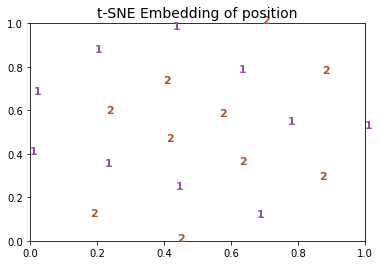

Starting compute PCA Embedding...


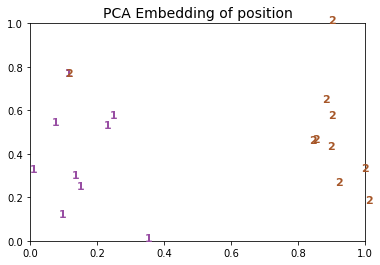

In [281]:
# t-SNE方法
# 对样本进行预处理并画图
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embedding(data, label, title):
    """
    :param data:数据集
    :param label:样本标签
    :param title:图像标题
    :return:图像
    """
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)		# 对数据进行归一化处理
    fig = plt.figure()		# 创建图形实例
    ax = plt.subplot(111)		# 创建子图
    # 遍历所有样本
    for i in range(data.shape[0]):
        # 在图中为每个数据点画出标签
        plt.text(data[i, 0], data[i, 1], str(label[i]), color=plt.cm.Set1(label[i] / 3),
                 fontdict={'weight': 'bold', 'size': 11})
    plt.xticks()		# 指定坐标的刻度
    plt.yticks()
    plt.title(title, fontsize=14)
    # 返回值
    return fig

print('Starting compute t-SNE Embedding...')
# ts = TSNE(n_components=2, init='pca', random_state=0)
ts = TSNE(n_components=2)#, init='pca', random_state=0)
# t-SNE降维
result = ts.fit_transform(dataSet)
# 调用函数，绘制图像
fig = plot_embedding(result, tardata, 't-SNE Embedding of position')
# 显示图像
plt.show()

# PCA降维
print('Starting compute PCA Embedding...')
pca = PCA(n_components=2)
result2 = pca.fit_transform(dataSet)
fig = plot_embedding(result2, tardata, 'PCA Embedding of position')
# 显示图像
plt.show()

In [ ]:
pred_attn = False
#pred_attn = True
layer_range = (0, layer2 if pred_attn else 22)
attrs = []
with torch.no_grad(): attentions = model(**inputs, output_attentions=True).attentions
for i in tqdm(range(*layer_range)):
    scaled_attn, step = scaled_input(attentions[i], 10)
    _ = scaled_attn.requires_grad_(True)
    m = get_attn_module(blocks[i])
    m.w = scaled_attn
    if pred_attn: blocks[layer2].exit = True
    try: outputs = model(**inputs, output_attentions=pred_attn)
    finally:
        m.w = None
        if pred_attn: blocks[layer2].exit = None
    y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] \
        if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
    
    attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    attn_grad = attn_grad.sum(dim=0, keepdim=True) # (bsz, H, qlen, klen) -> (1, H, qlen, klen)
    attr = attn_grad * step
    attrs.append(attr.data)
attrs = torch.cat([globalize(a) for a in attrs])
all_attrs[task_name][int(pred_attn)] = attrs #记录各个样例的注意力值分布

In [ ]:
tokens = [token.replace('Ġ', '').replace('Ċ', '^') for token in tokenizer.tokenize(_text)]
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print((i, token), end=' ')
seq_len = len(tokens)
answer = tokens[-1]
# src = [i for i, token in enumerate(tokens) if token in ['->', 'Ġ->']][-1]
# 用来找到答案的位置/变换的位置
tgt = [i for i, token in enumerate(tokens[:-1]) if token.lower() == answer.lower()][-1]
tgt

In [ ]:
def show_top_heads(values, indices, topk=20):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    top_heads = []
    for (l, h), v in zip(ind, val):
        if l < 4: continue
        top_heads.append((l, h, v, list(zip(unravel_index(indices[l, h], _attrs.size()[-2:]), numpy(values[l, h])))))
        print('%d-%d\t%.4f\t' % (l, h, v), top_heads[-1][-1], round(attns[l, h, src, tgt].item(), 4))

#pred_attn = False
ki = ans_positions[:-1]
attrs = all_attrs[task_name][int(pred_attn)]
# attrs = attrs / attrs.view(attrs.size(0), -1).norm(dim=1)[:, None, None, None] #.view(attrs.size(0), 1, 1, 1)
if not pred_attn:
    _attrs = attrs[:, :, src: src + 1, tgt: tgt + 1]
    values, indices = _attrs.view(_attrs.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices)
    print()

_attrs = attrs[:, :, src: src + 1, :]
values, indices = _attrs.view(_attrs.size(0), H, -1).topk(5, dim=-1)
show_top_heads(values, indices)

In [ ]:
ki

In [ ]:
layer, head = 10, 8 # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
# layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 5 # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [ ]:
_y
# _attn_grad[:, head, src, :]
_attn_grad[:, head, src, ki].mean(dim=-1)

In [ ]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
attn_grad[0, head - 2].mean()

In [ ]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [ ]:
h[layer].h_in = None
h[layer].attn.attention.attn_out = None
for l in range(layer, layer2): h[l].attn_output, h[l].ffn_output = None, None
am2 = h[layer2].attn.attention
am2.hidden_states, am2.attention_mask = None, None
try:
    with torch.no_grad(): outputs = model(**inputs)
finally:
    am2_hidden_states, am2_attention_mask = am2.hidden_states, am2.attention_mask
    delattr(am2, 'hidden_states')
    delattr(am2, 'attention_mask')

hidden_states = h[layer].h_in
for l in range(layer, layer2):
    if l in [layer2 - 1]: continue
    hidden_states = hidden_states + h[l].attn_output + h[l].ffn_output
(hidden_states - h[layer2].h_in).norm()

In [ ]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

In [ ]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

In [ ]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
top_heads = []
for l, attr in attrs.items():
    values, indices = attr[:, -1, :].reshape(-1).topk(5) # (H, klen) -> (H * klen,), reshape == view
    indices = unravel_index(indices, attr[:, -1, :].size())
    _top_heads = [(l, h, t, v) for h, t, v in zip(
        indices[0].tolist(), indices[1].tolist(), numpy(values))]
    print(_top_heads)
    top_heads += _top_heads

In [ ]:
head_attrs = {layer: attr[:, -1].max(dim=-1)[0] for layer, attr in attrs.items()}
top_heads = []
for l, attr in head_attrs.items():
    values, indices = attr.topk(5, dim=-1)
    values, indices = numpy(values), indices.tolist()
    top_heads += [(l, h, v) for h, v in zip(indices, values)]
    print([(l, h, v) for h, v in zip(indices, values)])
# top_heads

In [ ]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

In [ ]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

In [ ]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

In [ ]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [ ]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [ ]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

In [ ]:
import random

def get_random_string(gpt2_tokenizer):
    tokens = [gpt2_tokenizer.convert_ids_to_tokens(i) for i in range(120)]
    tokens = [token for token in tokens if token not in string.digits + string.ascii_uppercase + string.ascii_lowercase]
    tokens = ['Ġ' + token for token in tokens if gpt2_tokenizer._convert_token_to_id('Ġ' + token) != 50256]
    token_ids = [gpt2_tokenizer._convert_token_to_id(token) for token in tokens]  # XD
    print(tokens, len(tokens))
    
    sampled_tokens_idx = []
    sampled_tokens = []
    sampled_token_ids = []  # XD

    random.seed(6)  # XD
    #get sampled tokens idx
    range_ = list(range(len(tokens)))
    for i in range(362):
        idx = random.choice(range_)
        sampled_tokens_idx.append(idx)

    for idx in sampled_tokens_idx:
        sampled_tokens.append(tokens[idx])
        sampled_token_ids.append(token_ids[idx])

    text = ''.join(sampled_tokens).replace('Ġ', ' ')  # XD
    print(text, len(sampled_token_ids)) # XD
    return sampled_token_ids, text  # XD
    
    # print("".join(sampled_tokens), len(sampled_tokens))
    # return "".join(sampled_tokens), len(sampled_tokens)

token_ids, text = get_random_string(tokenizer)

In [ ]:
for name, p in model.named_parameters():
    print(name, p.size())

In [ ]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]